# Association Analysis and Item Based Colloborative Filtering Recommender 
#### *Saeed Nusri*

## Introduction

This report focuses on the analysis done on the sales transaction dataset from a UK retailer. The report presents exploratory data analysis and preparing the data for market basket analysis and building an item based collaborative filtering recommender system.



## Data Processing

The first step was to do some exploratory data analysis to remove outliers and replace the missing data.

In [1]:
import pandas as pd
import numpy as np
import random 
from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline


In [2]:
sales = pd.read_csv("sales_data.csv")

In [3]:
sales.head()

,OrderID,ProductID,ProductName,Quantity,OrderDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0


In [4]:
len(sales.index)

495478

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 7 columns):
OrderID        495478 non-null object
ProductID      495478 non-null object
ProductName    494024 non-null object
Quantity       495478 non-null int64
OrderDate      495478 non-null object
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 26.5+ MB


In [6]:
sales.isnull().sum()

OrderID             0
ProductID           0
ProductName      1454
Quantity            0
OrderDate           0
UnitPrice           0
CustomerID     133600
dtype: int64

In [7]:
sales.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


Preliminary exploration has shown that there are negative values for unit price and quantity. This does not seem right because none of these variables should have a negative value.

In [8]:
nosales = sales[sales["Quantity"] < 0]
print "Length of data with negative quantity: " + str(len(nosales.index))
nosales.head()

Length of data with negative quantity: 9192


,OrderID,ProductID,ProductName,Quantity,OrderDate,UnitPrice,CustomerID
121,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0
134,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0
201,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0
202,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0
203,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0


In [9]:
noprice = sales[sales["UnitPrice"] < 0]
print "Length of data with negative price: " + str(len(noprice.index))
print noprice

Length of data with negative price: 2
        OrderID ProductID      ProductName  Quantity            OrderDate  \
274532  A563186         B  Adjust bad debt         1  2011-08-12 14:51:00   
274533  A563187         B  Adjust bad debt         1  2011-08-12 14:52:00   

        UnitPrice  CustomerID  
274532  -11062.06         NaN  
274533  -11062.06         NaN  


It seems like the length of data that has negative values in quantity and unitprice account to about 1338 observations. These can be removed as they will affect the association analysis and recommendation system. 

In [10]:
frames = [noprice, nosales]
result = pd.concat(frames)

newsales = sales[~sales["OrderID"].isin(result["OrderID"])]

Now with the negative values have been dealt with, it is time to focus on the missing values. From the isnull function it was seen that there are 133600 customer IDs missing and 1454 product names missing as well. 

In [11]:
nocusID = newsales[sales["CustomerID"].isnull()]
len(nocusID.index)

/Users/Nusri/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


131939

In [12]:
noPN = newsales[newsales["ProductName"].isnull()]
len(noPN.index)

592

In [13]:
listPN = noPN["ProductID"].tolist()
len(newsales[newsales["ProductID"].isin(listPN)].index)

44928

In [14]:
noPN.head()

,OrderID,ProductID,ProductName,Quantity,OrderDate,UnitPrice,CustomerID
586,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN
1825,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN
1826,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN
1827,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN
1828,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN


In [15]:
noID_PN = newsales[newsales["CustomerID"].isnull() & newsales["ProductName"].isnull()]
len(noID_PN.index)

592

The 1454 records that don't have Product Name don't have Customer ID either.
Also the ProductName can be matched to the ProductID but it would be better to remove these values from the dataframe because they have 0 UnitPrice. This may be because it could have been a test transaction. For simplicity, it's better to remove these.

In [16]:
#Removing observations with no product names
newsales = newsales[~newsales["ProductName"].isnull()]
len(newsales.index)

485692

There are still quite a few missing Customer ID. To deal with the data, the best way to go about this is to fill the missing values from the existing list of customer IDs.

In [17]:

#Replacing the missing Customer ID with randomly choosing customerID from the dataset
newsales["CustomerID"].fillna(lambda x: random.choice(newsales[newsales["CustomerID"] != np.nan]["CustomerID"]), inplace = True)

In [18]:
#Checking for any missing values
newsales.isnull().sum()

OrderID        0
ProductID      0
ProductName    0
Quantity       0
OrderDate      0
UnitPrice      0
CustomerID     0
dtype: int64

Finally, rows with zero unit price is romoved from the dataset because it would essentially skew the results of the analysis. 

In [19]:
zeroUnitP = newsales[newsales["UnitPrice"] == 0]
len(zeroUnitP.index)

569

In [20]:
newsales = newsales[~(newsales["UnitPrice"] == 0)]



## Exploratory Data Analysis

EDA helps in getting to know your data better. The following section explores different aspects of the data and aims to make deductions about customer purchases. 

First aspect explored is which item had the most quantity of item sold. As seen below the top 5 items in this category have been plotted with "Paper Craft, Little Birdie" bring the most popular.

In [21]:
mostsoldprod = newsales.groupby(["ProductID", "ProductName"])["Quantity"].sum().reset_index().sort_values("Quantity", ascending = False)

mostsoldprod.reset_index(level = 0, inplace=True)
del mostsoldprod["index"]

mostsoldprod.head(10)

,ProductID,ProductName,Quantity
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,77036
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49526
3,85099B,JUMBO BAG RED RETROSPOT,44264
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35448
5,22197,POPCORN HOLDER,34738
6,84879,ASSORTED COLOUR BIRD ORNAMENT,33735
7,22616,PACK OF 12 LONDON TISSUES,25127
8,21212,PACK OF 72 RETROSPOT CAKE CASES,24986
9,22178,VICTORIAN GLASS HANGING T-LIGHT,23692


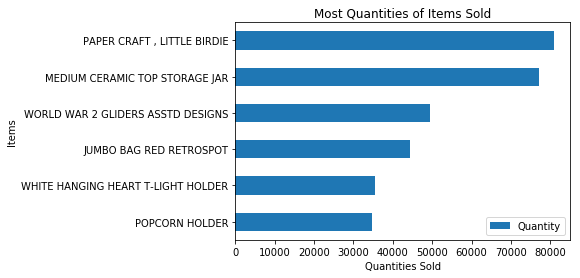

In [22]:
top5 = mostsoldprod.loc[0:5,["ProductName", "Quantity"]].sort_values("Quantity", ascending = True)
top5

top5.plot(kind = "barh", x = "ProductName", align = "center")
plt.ylabel('Items')
plt.xlabel('Quantities Sold')
plt.title('Most Quantities of Items Sold')

Another aspect that is examined was which product made the most sale. For this, the unit price was multiplied by the quantity and the values were stored in new NetSale column. The barchart shows the the product that made the most sale.

In [23]:
newsales["NetSales"] = newsales["Quantity"] * newsales["UnitPrice"]

In [24]:
highgrossprod = newsales.groupby(["ProductID","ProductName"])["NetSales"].sum().sort_values(ascending = False)
highgrossprod.head(5)



ProductID  ProductName                       
DOT        DOTCOM POSTAGE                        206248.77
23843      PAPER CRAFT , LITTLE BIRDIE           168469.60
22423      REGENCY CAKESTAND 3 TIER              142273.29
85123A     WHITE HANGING HEART T-LIGHT HOLDER     98545.24
47566      PARTY BUNTING                          93658.53
Name: NetSales, dtype: float64

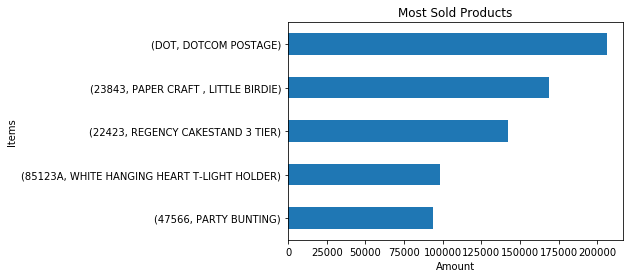

In [25]:
top5gros = highgrossprod[:5,].sort_values(ascending = True)

top5gros.plot(kind = "barh", x = "ProductName", align = "center")
plt.ylabel('Items')
plt.xlabel('Amount')
plt.title('Most Sold Products')

Also, the products which were most frequently sold were found as well. 

In [26]:
freqprod = newsales.groupby(["ProductID", "ProductName"])["ProductName"].count().sort_values(axis = 0,
                                                                                             ascending = 
                                                                                             False)
freqprod.head(5)

ProductID  ProductName                       
85123A     WHITE HANGING HEART T-LIGHT HOLDER    2160
85099B     JUMBO BAG RED RETROSPOT               1957
22423      REGENCY CAKESTAND 3 TIER              1710
47566      PARTY BUNTING                         1614
20725      LUNCH BAG RED RETROSPOT               1421
Name: ProductName, dtype: int64

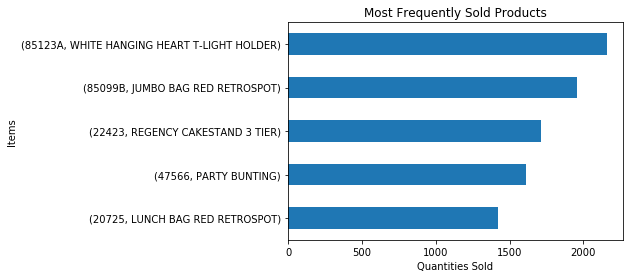

In [27]:
top5freq = freqprod[:5,].sort_values(ascending = True)

top5freq.plot(kind = "barh")
plt.ylabel('Items')
plt.xlabel('Quantities Sold')
plt.title('Most Frequently Sold Products')

Another area that can be explored is time, week and months in which the stores had most transactions.

In [28]:
newsales["OrderDate"] = pd.to_datetime(newsales["OrderDate"])

In [29]:
newsales["Hour"] = newsales["OrderDate"].dt.hour
newsales.head()

,OrderID,ProductID,ProductName,Quantity,OrderDate,UnitPrice,CustomerID,NetSales,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,20.34,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34,8


In [53]:
salesbyhour = newsales.groupby(["Hour"])["OrderID"].count()


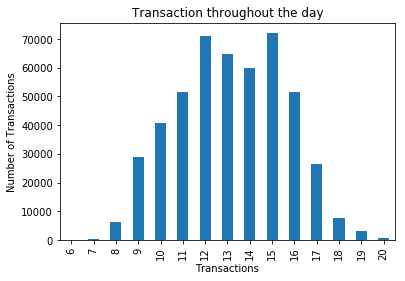

In [54]:
salesbyhour.plot(kind = "bar", x = "OrderID")
plt.xlabel("Transactions")
plt.ylabel("Number of Transactions")
plt.title("Transaction throughout the day")

The transactions were carried out between 6 AM to 8 PM and 11AM to 4 PM were the busiest time of the day. 

In [31]:
salesbyweek = newsales.groupby(["ProductID", 
                                pd.Grouper(key = "OrderDate", 
                                           freq = "W-MON")])["Quantity"].sum().reset_index().sort_values("Quantity", 
                                                                                                         ascending = False)

In [32]:
salesbyweek

,ProductID,OrderDate,Quantity
74692,23843,2011-12-12,80995
67604,23166,2011-01-24,74215
83323,84077,2011-10-31,5150
34411,22197,2011-05-30,4494
85243,84568,2011-08-01,4392
29298,22053,2011-02-28,3966
34439,22197,2011-12-12,3850
87680,84879,2011-08-08,3840
34435,22197,2011-11-14,3583
92654,85123A,2011-01-17,3537


In [33]:
newsales['weekday'] = newsales['OrderDate'].dt.weekday_name
newsales["weekday"] = newsales["weekday"].astype('O')
newsales

,OrderID,ProductID,ProductName,Quantity,OrderDate,UnitPrice,CustomerID,NetSales,Hour,weekday
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30,8,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,20.34,8,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,22.00,8,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34,8,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34,8,Wednesday
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,15.30,8,Wednesday
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,25.50,8,Wednesday
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,11.10,8,Wednesday
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,11.10,8,Wednesday
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,54.08,8,Wednesday


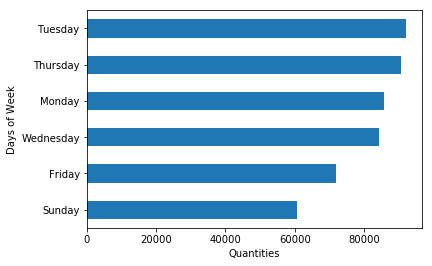

In [34]:
wd = newsales.groupby(['weekday'])['OrderID'].count().sort_values(ascending = True)

wd.plot(kind = "barh")
plt.xlabel("Quantities")
plt.ylabel("Days of Week")
plt.title("")

As seen from the bar chart above that Tuesdays were the busiest days of the week. Also note that Saturday is not present, which means that day the retail shop would be closed.

In [63]:
print newsales["OrderDate"].min()
print newsales["OrderDate"].max()

2010-12-01 08:26:00
2011-12-09 12:49:00


In [55]:
newsales['Month'] = newsales['OrderDate'].dt.strftime('%b')
newsales["Month"] = newsales["Month"].astype('O')

m = newsales.groupby(['Month'])['OrderID'].count().sort_values(ascending = True)

m.head()


Month
Feb    24850
Apr    27281
Aug    30471
Jan    31164
Jun    32388
Name: OrderID, dtype: int64

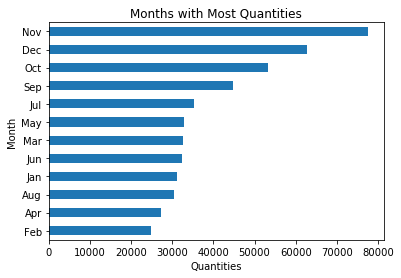

In [56]:
m.plot(kind = "barh")
plt.xlabel("Quantities")
plt.ylabel("Month")
plt.title("Months with Most Quantities")

Finally, given that the dataset ranges over an entire year, November was considered to be the month with the most amoubnt of transactions. This makes sense because it is closer to Christmas.

## Market Basket Analysis Using Association Analysis

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

Association Rules are widely used to analyze retail basket or transaction data, and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.
 
Some of the metric to consider in assoication analysis is as follows:
 
 - Support: The fraction of which our item set occurs in our dataset.
 - Confidence: probability that a rule is correct for a new transaction with items on the left.
 - Lift: The ratio by which by the confidence of a rule exceeds the expected confidence. 


First a matrix is created with OrderID as the index and ProductName as the columns and the matrix is populated with the quantities of each item. The quantity values are hot encoded to create a sparse matrix with 1s and 0s.

In [71]:
basket = (newsales.groupby(['OrderID', 'ProductName'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('OrderID'))

In [72]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.head()


ProductName,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
OrderID,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)


In [74]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()


,antecedants,consequents,support,confidence,lift
0,(LUNCH BAG CARS BLUE),(LUNCH BAG PINK POLKADOT),0.059104,0.441315,7.904619
1,(LUNCH BAG PINK POLKADOT),(LUNCH BAG CARS BLUE),0.055830,0.467197,7.904619
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.064321,0.677308,6.307190
3,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.107387,0.405685,6.307190
4,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.051723,0.618026,15.863541


In [77]:
rules[(rules['lift'] >= 6) & (rules['confidence'] >= 0.8)]

,antecedants,consequents,support,confidence,lift
5,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038959,0.820513,15.863541
25,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.030246,0.902752,17.453534
26,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.031966,0.854167,16.099612
49,"(JUMBO BAG PINK POLKADOT, JUMBO SHOPPER VINTAG...",(JUMBO BAG RED RETROSPOT),0.025196,0.806167,7.507147
57,"(JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI)",(JUMBO BAG RED RETROSPOT),0.028026,0.801980,7.468156


## Coocurence Matrix

To find out the popular items are bought together  we need to first create a matrix of Customer ID and User. Multiplying the matrix with its transpose would yield the coccurence matrix. 

We can take basket_sets from the association analysis to get the coocurence matrix.


In [133]:
CID_PN_matrix = newsales.pivot_table(index = ["CustomerID"], columns = ["ProductName"], 
                              values = "Quantity").fillna(0)

basket_set = CID_PN_matrix.applymap(encode_units)

basket_sets_int = basket_set.astype(int)

coocM = basket_sets_int.T.dot(basket_sets_int)


In [134]:
coocM.head()

ProductName,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
ProductName,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,31,1,2,2,1,2,1,3,1,0,...,0,2,2,3,0,3,1,4,1,2
50'S CHRISTMAS GIFT BAG LARGE,1,97,5,4,1,4,27,5,8,0,...,0,3,4,4,0,13,1,4,1,1
DOLLY GIRL BEAKER,2,5,78,7,1,3,6,7,12,0,...,0,2,4,8,0,11,1,2,2,3
I LOVE LONDON MINI BACKPACK,2,4,7,47,2,3,4,11,7,0,...,0,3,4,3,0,4,1,5,1,3
NINE DRAWER OFFICE TIDY,1,1,1,2,25,2,1,2,2,0,...,0,1,2,1,0,2,2,2,1,1


Finally, finding the max values of the cooccurence matrix would tell us which items are usually bought together. It should be noted that the highest value in cooccurance matrix corresponds to the This is a simpler approach to Market Basket Analysis which tells us about item pairs frquently bought but it is heavily dependent on the quantity and hence is not as accurate.

In [130]:
x = pd.DataFrame(coocM.idxmax()).reset_index()
x.columns = ["A", "B"]

r = x[x["A"] != x["B"]]
r.head(10)

,A,B
11,*Boombox Ipod Classic,OVAL WALL MIRROR DIAMANTE
12,*USB Office Mirror Ball,SET 2 TEA TOWELS I LOVE LONDON
79,4 GOLD FLOCK CHRISTMAS BALLS,SET 2 TEA TOWELS I LOVE LONDON
133,"ACRYLIC JEWEL SNOWFLAKE,PINK",4 PINK FLOCK CHRISTMAS BALLS
157,AMBER BERTIE MOBILE PHONE CHARM,SPACEBOY BABY GIFT SET
167,AMETHYST 3 BEAD DROP EARRINGS,12 PENCIL SMALL TUBE WOODLAND
185,ANT SILVER PURPLE BOUDICCA RING,ANT SILVER LIME GREEN BOUDICCA RING
201,ANTIQUE SILVER BOOK MARK WITH BEADS,200 RED + WHITE BENDY STRAWS
229,ASSORTED COLOUR SILK GLASSES CASE,10 COLOUR SPACEBOY PEN
256,ASSTD DESIGN BUBBLE GUM RING,12 MESSAGE CARDS WITH ENVELOPES


## Recommender - Item Based Collaborative Filter

Item based collaborative filtering is a model-based algorithm for recommender engines. In item based collaborative filtering similarities between items are calculated from rating-matrix. And based upon these similarities, user’s preference for an item not rated by him is calculated. In this case, quantities is used as a measure of "rating". This might not be the most accurate way but would provide strong similarities between products that are bought in bulk.

First a matrix of CustomerID and ProductName is created just like we did for association analysis  using pandas pivot table function and the NaNs are filled with zeroes.

In [105]:
matrix = newsales.pivot_table(index = ["CustomerID"], columns = ["ProductName"], 
                              values = "Quantity")
matrix.head(10)

ProductName,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12747.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12748.0,NaN,8.0,NaN,1.0,NaN,1.0,20.0,1.4,1.0,NaN,...,NaN,1.0,1.0,NaN,NaN,5.5,NaN,NaN,NaN,NaN
12749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.0,NaN,12.0,NaN,NaN,NaN,NaN
12820.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12823.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12824.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN


Then a product is selected to see which customers have bought this product. The ones's who have will have show the quantity they have bought and the ones who have not will have NaN shown. In this case we have chosen the WHITE HANGING HEART T-LIGHT HOLDER.

In [108]:
whiteHeart = matrix["WHITE HANGING HEART T-LIGHT HOLDER"]
whiteHeart.head()

CustomerID
12346.0         NaN
12747.0    9.000000
12748.0    7.285714
12749.0         NaN
12820.0    6.000000
Name: WHITE HANGING HEART T-LIGHT HOLDER, dtype: float64

A correlation matrix is created for the WHITE HANGING HEART T-LIGHT HOLDER to see which products are similar to this product.

In [39]:
similarProductsW = matrix.corrwith(whiteHeart)
similarProductsW = similarProductsW.dropna()
df = pd.DataFrame(similarProductsW)
df.head(10)

/Users/Nusri/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/Nusri/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,0
ProductName,
4 PURPLE FLOCK DINNER CANDLES,0.414782
50'S CHRISTMAS GIFT BAG LARGE,0.724731
DOLLY GIRL BEAKER,0.588408
I LOVE LONDON MINI BACKPACK,0.834675
NINE DRAWER OFFICE TIDY,0.586112
OVAL WALL MIRROR DIAMANTE,0.687362
RED SPOT GIFT BAG LARGE,0.467221
SET 2 TEA TOWELS I LOVE LONDON,0.608313
SPACEBOY BABY GIFT SET,0.449476


In [40]:
similarProductsW.order(ascending = False)

/Users/Nusri/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


ProductName
ROSE COLOUR PAIR HEART HAIR SLIDES     1.0
VINTAGE KITCHEN PRINT SEAFOOD          1.0
PINK STRAWBERRY HANDBAG                1.0
ENVELOPE 50 ROMANTIC IMAGES            1.0
PINK VINTAGE VICTORIAN EARRINGS        1.0
ASS COL CIRCLE MOBILE                  1.0
PINK/BLUE STRING CURTAIN               1.0
PINK/YELLOW FLOWERS HANDBAG            1.0
GREEN HEART OF GLASS BRACELET          1.0
GREEN MURANO TWIST BRACELET            1.0
GREEN VINTAGE EARRINGS                 1.0
POCKET MIRROR WOODLAND                 1.0
EIGHT PIECE CREEPY CRAWLIE SET         1.0
POTTING SHED CANDLE CITRONELLA         1.0
PURPLE ACRYLIC FACETED BANGLE          1.0
PURPLE DRESS JEWELLERY STAND           1.0
VINTAGE ZINC WATERING CAN              1.0
VINTAGE ZINC PLANTER                   1.0
WOODLAND STORAGE BOX SMALL             1.0
RED   ACRYLIC FACETED BANGLE           1.0
MURANO STYLE GLASS BRACELET GOLD       1.0
DROP DIAMANTE EARRINGS CRYSTAL         1.0
DOTCOMGIFTSHOP TEA TOWEL               1.0

It seems like a like there are a lot of products that have high correlation(similarity) with the WHITE HANGING HEART T-LIGHT HOLDER.

However, to make our recommendation more accurate and user specific we choose a customer from the dataset, see what she has bought and see which products are the closest to the ones she has bought using the correlation matrix. 

Below is a similarity matrix. It has all the products that have a good relationship with each other.

In [64]:
corrMatrix = matrix.corr()
corrMatrix.head()

ProductName,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
ProductName,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.0,NaN,1.000000,1.000000,NaN,1.000000,NaN,-0.423415,NaN,NaN,...,NaN,NaN,NaN,-0.512360,NaN,0.995818,NaN,0.902332,NaN,-1.000000
50'S CHRISTMAS GIFT BAG LARGE,NaN,1.000000,0.846148,0.796587,NaN,-0.705370,0.998221,0.992191,0.318918,NaN,...,NaN,NaN,0.512033,1.000000,NaN,0.685869,NaN,0.739845,NaN,NaN
DOLLY GIRL BEAKER,1.0,0.846148,1.000000,0.937290,NaN,0.924640,0.372885,0.923167,0.172355,NaN,...,NaN,NaN,0.936631,0.812971,NaN,0.855600,NaN,1.000000,NaN,0.982484
I LOVE LONDON MINI BACKPACK,1.0,0.796587,0.937290,1.000000,-1.0,0.978751,0.326869,0.689657,0.370767,NaN,...,NaN,NaN,0.988042,0.988320,NaN,0.992617,NaN,0.074766,NaN,0.976688
NINE DRAWER OFFICE TIDY,NaN,NaN,NaN,-1.000000,1.0,-1.000000,NaN,1.000000,-1.000000,NaN,...,NaN,NaN,-1.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN


In [65]:
second_customer = matrix.iloc[1].dropna()
second_customer.head()

ProductName
3 DRAWER ANTIQUE WHITE WOOD CABINET     2.000000
ASSORTED COLOUR BIRD ORNAMENT          17.333333
BLUE JUICY FRUIT PHOTO FRAME            6.000000
CREAM SWEETHEART LETTER RACK            6.000000
DOORMAT BLACK FLOCK                     2.000000
Name: 12747.0, dtype: float64

In [113]:
simProducts = pd.Series()
#Go through every product bought by second customer
for i in range(0, len(second_customer.index)):
    print "Adding sims for " + second_customer.index[i] + "...."
    #Retrieve similar products to the ones bought by customer 2
    sims = corrMatrix[second_customer.index[i]].dropna()
    #Scale to how many of the products were bought
    sims = sims.map(lambda x: x * second_customer[i])
    # Add to the list of similar products
    simProducts = simProducts.append(sims)

print "sorting..."
simProducts.sort_values(inplace = True, ascending = True)
print simProducts

    

Adding sims for 3 DRAWER ANTIQUE WHITE WOOD CABINET....
Adding sims for ASSORTED COLOUR BIRD ORNAMENT....
Adding sims for BLUE JUICY FRUIT PHOTO FRAME....
Adding sims for CREAM SWEETHEART LETTER RACK....
Adding sims for DOORMAT BLACK FLOCK ....
Adding sims for DOORMAT HEARTS....
Adding sims for DOORMAT UNION FLAG....
Adding sims for ENAMEL BREAD BIN CREAM....
Adding sims for ENAMEL COLANDER CREAM....
Adding sims for ENAMEL FLOWER JUG CREAM....
Adding sims for ENAMEL MEASURING JUG CREAM....
Adding sims for ENAMEL WATERING CAN CREAM....
Adding sims for GAOLERS KEYS DECORATIVE GARDEN ....
Adding sims for GREEN JUICY FRUIT PHOTO FRAME....
Adding sims for HANGING JAM JAR T-LIGHT HOLDER....
Adding sims for HEART OF WICKER SMALL....
Adding sims for HOME BUILDING BLOCK WORD....
Adding sims for JUMBO  BAG BAROQUE BLACK WHITE....
Adding sims for JUMBO BAG ALPHABET....
Adding sims for JUMBO BAG APPLES....
Adding sims for JUMBO BAG PAISLEY PARK....
Adding sims for JUMBO BAG PEARS....
Adding sims f

In [117]:
#Sorting the results and avoid repetitions
simProducts= simProducts.groupby(simProducts.index).sum().sort_values(ascending = False)

Hence, top 5 recommendation for customer would be as follows based on the quantities of the items this customer has bought.

In [119]:
filteredSims = simProducts.drop(second_customer.index)
filteredSims.head(5)

WALL ART DOLLY GIRL                    333.437095
CHRISTMAS LIGHTS 10 VINTAGE BAUBLES    320.530100
CERAMIC BOWL WITH STRAWBERRY DESIGN    319.868741
HOME SWEET HOME 3 PEG HANGER           318.763339
MAGNETS PACK OF 4 VINTAGE LABELS       316.430200
dtype: float64

## Conclusion



This notebook presents the analysis on the sales transaction data. It starts off with data processing, followed by exploratory data analysis that told a lot about the dataset. Different aspects were explored that helped us make deductions about the store. For instance, we came came to know which hour of day, day of the week and month of year were the busiest for the store. Also, the net sales, most quatitities sold, and most frequently sold of the top5 were visualized.

EDA was followed by Market Basket Analysis using association analysis. This is a technique typically used to find which products are brought together using support, confidence and lift metrics. The algorithm that makes it easier is apriori.

Another techni